In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Artist Recognition

In [2]:
# Resources: https://www.kaggle.com/supratimhaldar/deepartist-identify-artist-from-art
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#seeds:
np.random.seed(123)
tf.random.set_seed(123)

# Intuition
- Model should classify the artist and not objects in painting
    - this requires understanding of paint style -> shallow layers > deep layers

# Image Exploration

In [4]:
images_dir = '../input/best-artworks-of-all-time/resized/resized'
artists_dirs = list(set([" ".join(filename.split("_")[:-1]) for filename in os.listdir(images_dir)])) #get all names from /resized/resized
n_classes = len(artists_dirs)
print(artists_dirs)

['William Turner', 'Henri de Toulouse-Lautrec', 'Albrecht Du╠êrer', 'Edgar Degas', 'Camille Pissarro', 'Salvador Dali', 'Raphael', 'Gustave Courbet', 'Frida Kahlo', 'Amedeo Modigliani', 'Eugene Delacroix', 'Leonardo da Vinci', 'Paul Klee', 'Rene Magritte', 'Pierre-Auguste Renoir', 'Paul Gauguin', 'Rembrandt', 'Titian', 'Pablo Picasso', 'Georges Seurat', 'Kazimir Malevich', 'Paul Cezanne', 'Piet Mondrian', 'Vasiliy Kandinskiy', 'Edouard Manet', 'Jan van Eyck', 'Henri Matisse', 'Pieter Bruegel', 'Claude Monet', 'Jackson Pollock', 'Mikhail Vrubel', 'Diego Rivera', 'Vincent van Gogh', 'Andy Warhol', 'Diego Velazquez', 'Marc Chagall', 'Edvard Munch', 'Michelangelo', 'Albrecht Dürer', 'Francisco Goya', 'Caravaggio', 'Giotto di Bondone', 'Peter Paul Rubens', 'Gustav Klimt', 'Sandro Botticelli', 'Andrei Rublev', 'El Greco', 'Alfred Sisley', 'Henri Rousseau', 'Hieronymus Bosch', 'Joan Miro']


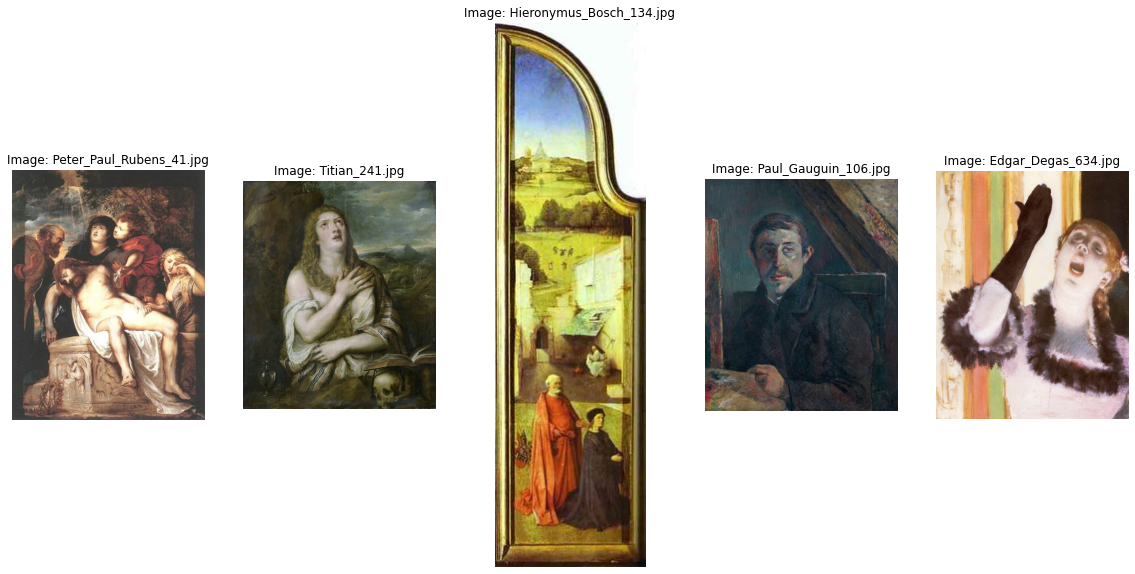

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(20,10))

for i in range(5):
    random_image = random.choice(os.listdir(os.path.join(images_dir)))
    random_image_file = os.path.join(images_dir, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Image: " + random_image)
    axes[i].axis('off')

plt.show()

# Prerequisites

In [6]:
# using the /images/ folder because the folder structure is aligned with the requirements of keras
artists_dirs = list(os.listdir('../input/best-artworks-of-all-time/images/images'))
images_dir = '../input/best-artworks-of-all-time/images/images'

In [7]:
batch_size = 16
train_input_shape = (224, 224, 3)

In [8]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_dirs
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_dirs
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

#Error because folder structure doesn't match the one required by tf (in case of /resized/resized)
#Check this out: https://datascience.stackexchange.com/questions/65979/what-is-the-correct-way-to-call-keras-flow-from-directory-method

Found 7042 images belonging to 51 classes.
Found 1732 images belonging to 51 classes.
Total number of batches = 440 and 108


# Build Model

In [9]:
train_input_shape = (224, 224, 3)

In [10]:
# Pre-trained model (requires activated internet-access in kaggle)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


# Build NN

In [11]:
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [12]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
n_epoch = 5 #takes way too long for anything > 1

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [14]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16
                             )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
440/440 [==============================] - 118s 234ms/step - loss: 3.4693 - accuracy: 0.2182 - val_loss: 3.9148 - val_accuracy: 0.0289
Epoch 2/5
440/440 [==============================] - 103s 229ms/step - loss: 3.0961 - accuracy: 0.3560 - val_loss: 3.7972 - val_accuracy: 0.1372
Epoch 3/5
440/440 [==============================] - 104s 232ms/step - loss: 2.8145 - accuracy: 0.4409 - val_loss: 2.6803 - val_accuracy: 0.4427
Epoch 4/5
440/440 [==============================] - 107s 237ms/step - loss: 2.5724 - accuracy: 0.4922 - val_loss: 2.5705 - val_accuracy: 0.4664
Epoch 5/5
440/440 [==============================] - 104s 231ms/step - loss: 2.3514 - accuracy: 0.5309 - val_loss: 2.3508 - val_accuracy: 0.4803


In [15]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 8
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16
                             )

Epoch 1/8
440/440 [==============================] - 107s 229ms/step - loss: 1.7380 - accuracy: 0.6174 - val_loss: 2.1051 - val_accuracy: 0.5249
Epoch 2/8
440/440 [==============================] - 102s 226ms/step - loss: 1.6590 - accuracy: 0.6137 - val_loss: 2.1248 - val_accuracy: 0.5093
Epoch 3/8
440/440 [==============================] - 105s 232ms/step - loss: 1.6276 - accuracy: 0.6181 - val_loss: 2.0708 - val_accuracy: 0.5110
Epoch 4/8
440/440 [==============================] - 103s 228ms/step - loss: 1.5901 - accuracy: 0.6206 - val_loss: 2.0915 - val_accuracy: 0.5150
Epoch 5/8
440/440 [==============================] - 105s 229ms/step - loss: 1.5799 - accuracy: 0.6225 - val_loss: 2.0209 - val_accuracy: 0.5208
Epoch 6/8
440/440 [==============================] - 103s 230ms/step - loss: 1.5594 - accuracy: 0.6268 - val_loss: 2.0315 - val_accuracy: 0.5208
Epoch 7/8
440/440 [==============================] - 103s 227ms/step - loss: 1.5395 - accuracy: 0.6237 - val_loss: 2.0560 - val_ac

# Prediction

In [16]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


441/441 [==============================] - 171s 387ms/step - loss: 1.4931 - accuracy: 0.6353
Prediction accuracy on train data = 0.635330855846405


In [17]:
# Acccuracy
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

109/109 [==============================] - 42s 382ms/step - loss: 2.0217 - accuracy: 0.5231
Prediction accuracy on CV data = 0.5230947136878967


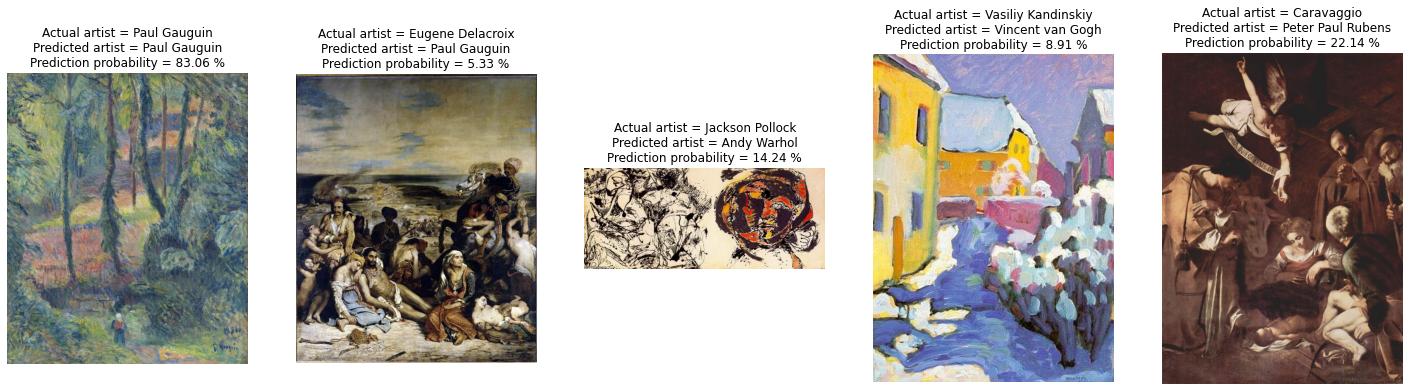

In [18]:
# Prediction
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_dirs)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())


    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

In [19]:
save_model(model, 'vgg19_model.h5')


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
import json

with open('labels.json', 'w') as fp:
    json.dump(labels, fp)




